In [1]:
import arviz as az
import os.path as op
from tqdm.contrib.itertools import product
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
# Distance to RNP
from risk_experiment.cogmodels.fit_probit import build_model, get_data
from risk_experiment.cogmodels.utils import get_fake_data, extract_intercept_gamma
cm = 1/2.54  # centimeters in inches

palette = sns.color_palette()[8:]
order = ['Low pupil dilation', 'High pupil dilation']

/Users/gdehol/mambaforge/lib/python3.10/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
bids_folder ='/data/ds-risk'

In [3]:
def load(model_label, session, bids_folder='/data/ds-risk'):
    df = get_data(model_label, session, bids_folder)
    model = build_model(model_label, df, session, bids_folder)
    idata = az.from_netcdf(f'/data/ds-risk/derivatives/cogmodels/model-{model_label}_ses-{session}_trace.netcdf')

    return df, model, idata

def get_hdi(x):
    return tuple(az.hdi(x.values))

# Super simple model (pupil split)

## N1_pre

In [4]:
df, model, idata = load('probit_pupil_median_split1_n1_pre', '3t2')

100%|██████████| 30/30 [00:02<00:00, 13.57it/s]


N1_PRE


0.331

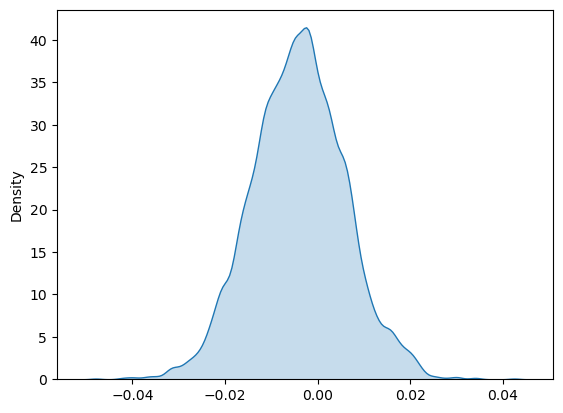

In [5]:
intercept, gamma = extract_intercept_gamma(idata, model, df, group=True)
rnp = np.exp(intercept['intercept']/gamma['gamma']).stack([-2, -1]).to_frame('rnp')
rnp.index = rnp.index.set_levels(rnp.index.levels[1].astype(int), level=1)

gamma = gamma.stack([-2, -1])

tmp = rnp.unstack('median_split_pupil')['rnp']

diff = tmp['High pupil dilation'] - tmp['Low pupil dilation']
sns.kdeplot(diff, fill=True)
(diff > 0.0).mean()

0.48925

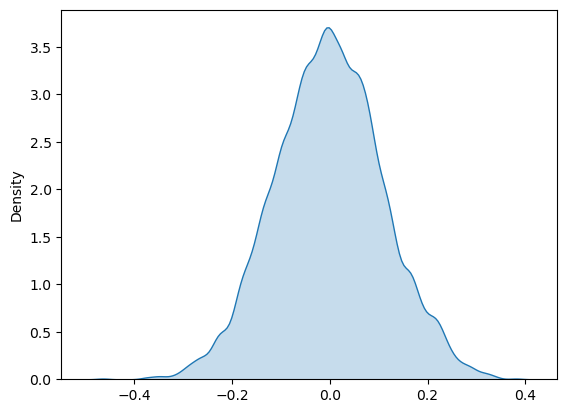

In [6]:
tmp = gamma.unstack('median_split_pupil')['gamma']
diff = tmp['High pupil dilation'] - tmp['Low pupil dilation']
sns.kdeplot(diff, fill=True)
(diff > 0.0).mean()

## N1 pre_post

100%|██████████| 30/30 [00:01<00:00, 25.88it/s]


N1_PREPOST


0.832

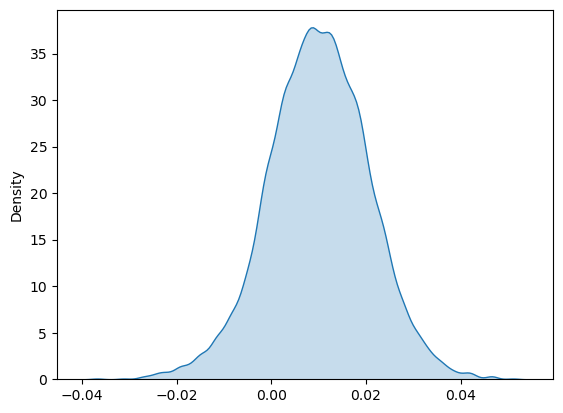

In [7]:
df, model, idata = load('probit_pupil_median_split1_n1_prepost', '3t2')

intercept, gamma = extract_intercept_gamma(idata, model, df, group=True)
rnp = np.exp(intercept['intercept']/gamma['gamma']).stack([-2, -1]).to_frame('rnp')
rnp.index = rnp.index.set_levels(rnp.index.levels[1].astype(int), level=1)

gamma = gamma.stack([-2, -1])

tmp = rnp.unstack('median_split_pupil')['rnp']

diff = tmp['High pupil dilation'] - tmp['Low pupil dilation']
sns.kdeplot(diff, fill=True)
(diff > 0.0).mean()

0.55375

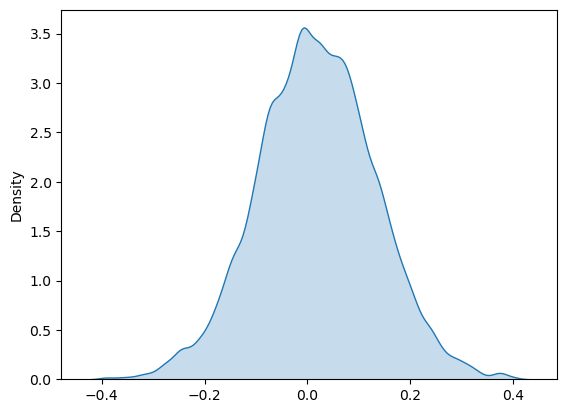

In [8]:
tmp = gamma.unstack('median_split_pupil')['gamma']
diff = tmp['High pupil dilation'] - tmp['Low pupil dilation']
sns.kdeplot(diff, fill=True)
(diff > 0.0).mean()

## n2 choice

100%|██████████| 30/30 [00:01<00:00, 27.73it/s]


N2_CHOICE


0.458

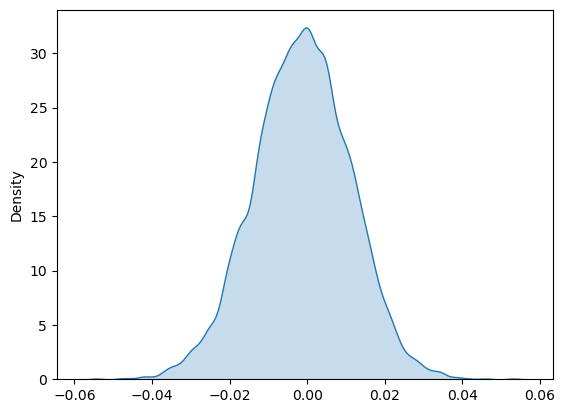

In [9]:
df, model, idata = load('probit_pupil_median_split1_n2_choice', '3t2')

intercept, gamma = extract_intercept_gamma(idata, model, df, group=True)
rnp = np.exp(intercept['intercept']/gamma['gamma']).stack([-2, -1]).to_frame('rnp')
rnp.index = rnp.index.set_levels(rnp.index.levels[1].astype(int), level=1)

gamma = gamma.stack([-2, -1])

tmp = rnp.unstack('median_split_pupil')['rnp']

diff = tmp['High pupil dilation'] - tmp['Low pupil dilation']
sns.kdeplot(diff, fill=True)
(diff > 0.0).mean()

0.0395

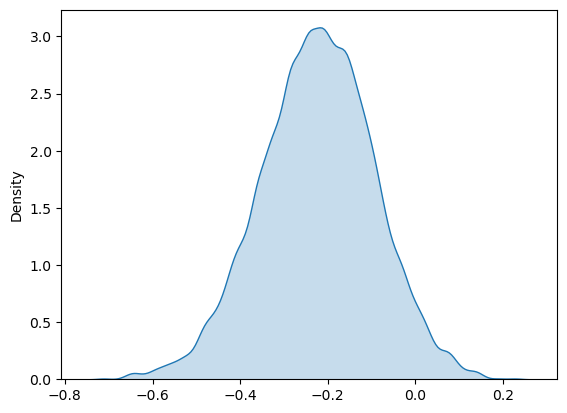

In [10]:
tmp = gamma.unstack('median_split_pupil')['gamma']
diff = tmp['High pupil dilation'] - tmp['Low pupil dilation']
sns.kdeplot(diff, fill=True)
(diff > 0.0).mean()

# Simple model (order x pupil split)

## n1 Pre

In [4]:
df, model, idata = load('probit_pupil_median_split3_n1_pre', '3t2')


100%|██████████| 30/30 [00:01<00:00, 24.34it/s]


N1_PRE


In [5]:
df.pupil.describe()

count    5760.000000
mean        0.098179
std         0.922801
min        -3.072807
25%        -0.528594
50%         0.031886
75%         0.656898
max         4.751155
Name: pupil, dtype: float64

In [6]:
intercept, gamma = extract_intercept_gamma(idata, model, df, group=True)
rnp = np.exp(intercept['intercept']/gamma['gamma']).stack([-2, -1]).to_frame('rnp')
rnp.index = rnp.index.set_levels(rnp.index.levels[1].astype(int), level=1)

gamma = gamma.stack([-2, -1])

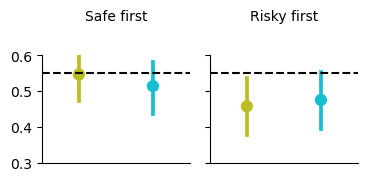

In [7]:
rnp['Order'] = rnp.index.get_level_values('risky_first').map({True:'Risky first', False:'Safe first'})
rnp['Pupil size'] = rnp.index.get_level_values('median_split_pupil')#.map({True:'Large', False:'Small'})


fac = sns.catplot(data=rnp.reset_index(), x='Pupil size', y='rnp', col='Order', kind='point', palette=palette,
                   order=['Low pupil dilation', 'High pupil dilation'],
                   errorbar=get_hdi,
                #   col_order=['Safe first', 'Risky first'],
                  aspect=1., height=1.5*3.2*cm, legend=False)

fac.set(ylabel=None, xlabel=None, xticks=[], ylim=(0.3, 0.6))
fac.set_titles('{col_name}', y=1.25)
# fac.add_legend()

fac.map(lambda *args, **kwargs: plt.axhline(0.55, c='k', ls='--'))


plt.savefig(op.join(bids_folder, 'derivatives', 'figures', 'pupil_n1_pre_rnp.pdf'), bbox_inches='tight')

/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  self._figure.tight_layout(*args, **kwargs)


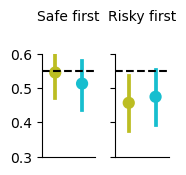

In [14]:
rnp['Order'] = rnp.index.get_level_values('risky_first').map({True:'Risky first', False:'Safe first'})
rnp['Pupil size'] = rnp.index.get_level_values('median_split_pupil')#.map({True:'Large', False:'Small'})


fac = sns.catplot(data=rnp.reset_index(), x='Pupil size', y='rnp', col='Order', kind='point', palette=palette,
                   order=['Low pupil dilation', 'High pupil dilation'],
                   errorbar=get_hdi,
                #   col_order=['Safe first', 'Risky first'],
                  aspect=.5, height=1.5*3.2*cm, legend=False)

fac.set(ylabel=None, xlabel=None, xticks=[], ylim=(0.3, 0.6))
fac.set_titles('{col_name}', y=1.25)
# fac.add_legend()

fac.map(lambda *args, **kwargs: plt.axhline(0.55, c='k', ls='--'))


# plt.savefig(op.join(bids_folder, 'derivatives', 'figures', 'pupil_n1_prepost_rnp.pdf'), bbox_inches='tight')

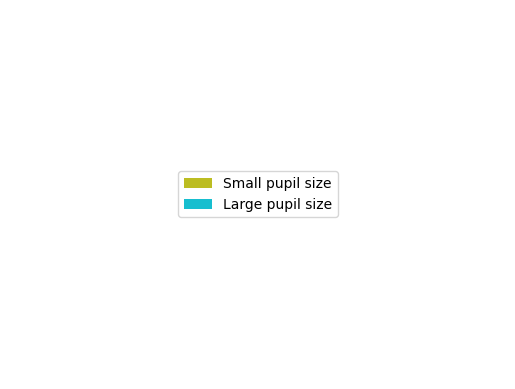

In [8]:
from matplotlib.lines import Line2D
from matplotlib.patches import Patch


fig = plt.gcf()

legend_elements = [Patch(facecolor=palette[0], label='Small pupil size'),
                   Patch(facecolor=palette[1], label='Large pupil size') ]


legend = plt.legend(handles=legend_elements, loc='center')
plt.axis('off')

bbox  = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
# fig.savefig(filename, dpi="figure", bbox_inches=bbox)

plt.savefig('/data/ds-risk/derivatives/figures/pupil_legend.pdf', bbox_inches=bbox)

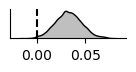

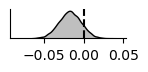

In [9]:
diff = (rnp.xs(False, 0, 'risky_first').xs('Low pupil dilation', 0, 'median_split_pupil')['rnp'] - rnp.xs(False, 0, 'risky_first').xs('High pupil dilation', 0, 'median_split_pupil')['rnp']) 

sns.kdeplot(diff, fill=True, color='k')
sns.despine()

plt.axvline(0.0, c='k', ls='--')
sns.despine()
plt.gcf().set_size_inches(1.5, .375)
plt.xlabel(None)
plt.ylabel(None)
plt.yticks([])

plt.savefig('/data/ds-risk/derivatives/figures/pupil_n1_pre_rnp_safe_first_diff.pdf', bbox_inches='tight')

plt.figure()
diff = (rnp.xs(True, 0, 'risky_first').xs('Low pupil dilation', 0, 'median_split_pupil')['rnp'] - rnp.xs(True, 0, 'risky_first').xs('High pupil dilation', 0, 'median_split_pupil')['rnp']) 

sns.kdeplot(diff, fill=True, color='k')
sns.despine()

plt.axvline(0.0, c='k', ls='--')
sns.despine()
plt.gcf().set_size_inches(1.5, .375)
plt.xlabel(None)
plt.ylabel(None)
plt.yticks([])

plt.savefig('/data/ds-risk/derivatives/figures/pupil_n1_pre_rnp_risky_first_diff.pdf', bbox_inches='tight')

In [10]:
print(((rnp.xs(False, 0, 'risky_first').xs('Low pupil dilation', 0, 'median_split_pupil')['rnp'] - rnp.xs(False, 0, 'risky_first').xs('High pupil dilation', 0, 'median_split_pupil')['rnp']) < 0.0).mean())
print(((rnp.xs(True, 0, 'risky_first').xs('Low pupil dilation', 0, 'median_split_pupil')['rnp'] - rnp.xs(True, 0, 'risky_first').xs('High pupil dilation', 0, 'median_split_pupil')['rnp']) > 0.0).mean())

0.00875
0.1095


0.0035

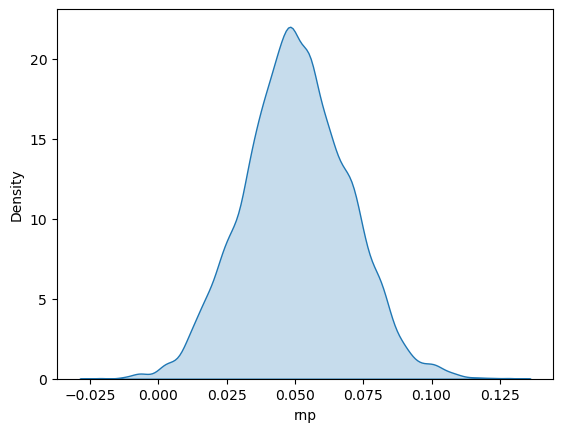

In [11]:
diff1 = (rnp.xs(False, 0, 'risky_first').xs('Low pupil dilation', 0, 'median_split_pupil')['rnp'] - rnp.xs(False, 0, 'risky_first').xs('High pupil dilation', 0, 'median_split_pupil')['rnp'])
diff2 = (rnp.xs(True, 0, 'risky_first').xs('Low pupil dilation', 0, 'median_split_pupil')['rnp'] - rnp.xs(True, 0, 'risky_first').xs('High pupil dilation', 0, 'median_split_pupil')['rnp'])

sns.kdeplot(diff1 - diff2, fill=True)

((diff2 - diff1) > 0.0).mean()

/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  self._figure.tight_layout(*args, **kwargs)


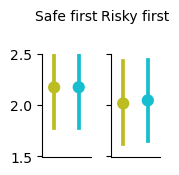

In [19]:
gamma['Order'] = gamma.index.get_level_values('risky_first').map({True:'Risky first', False:'Safe first'})
gamma['Pupil size'] = gamma.index.get_level_values('median_split_pupil')


fac = sns.catplot(data=gamma.reset_index(), x='Pupil size', y='gamma', col='Order', kind='point', palette=palette,
                   order=['Low pupil dilation', 'High pupil dilation'],
                   errorbar=get_hdi,
                   col_order=['Safe first', 'Risky first'],
                   aspect=.5, height=1.5*3.2*cm, legend=False)

fac.set(ylabel=None, xlabel=None, xticks=[], ylim=(1.5, 2.5))
fac.set_titles('{col_name}', y=1.25)

# fac.map(lambda *args, **kwargs: plt.axhline(0.55, c='k', ls='--'))
plt.tight_layout()

plt.savefig(op.join(bids_folder, 'derivatives', 'figures', 'pupil_n1_pre_gamma.pdf'), bbox_inches='tight')

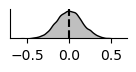

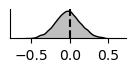

In [26]:
diff = (gamma.xs(False, 0, 'risky_first').xs('Low pupil dilation', 0, 'median_split_pupil')['gamma'] - gamma.xs(False, 0, 'risky_first').xs('High pupil dilation', 0, 'median_split_pupil')['gamma']) 

sns.kdeplot(diff, fill=True, color='k')
sns.despine()

plt.axvline(0.0, c='k', ls='--')
sns.despine()
plt.gcf().set_size_inches(1.5, .375)
plt.xlabel(None)
plt.ylabel(None)
plt.yticks([])

plt.savefig('/data/ds-risk/derivatives/figures/pupil_n1_pre_gamma_safe_first_diff.pdf', bbox_inches='tight')

plt.figure()
diff = (gamma.xs(True, 0, 'risky_first').xs('Low pupil dilation', 0, 'median_split_pupil')['gamma'] - gamma.xs(True, 0, 'risky_first').xs('High pupil dilation', 0, 'median_split_pupil')['gamma']) 

sns.kdeplot(diff, fill=True, color='k')
sns.despine()

plt.axvline(0.0, c='k', ls='--')
sns.despine()
plt.gcf().set_size_inches(1.5, .375)
plt.xlabel(None)
plt.ylabel(None)
plt.yticks([])

plt.savefig('/data/ds-risk/derivatives/figures/pupil_n1_pre_gamma_risky_first_diff.pdf', bbox_inches='tight')

In [27]:
print( 1-((gamma.xs(False, 0, 'risky_first').xs('Low pupil dilation', 0, 'median_split_pupil')['gamma'] - gamma.xs(False, 0, 'risky_first').xs('High pupil dilation', 0, 'median_split_pupil')['gamma']) < 0.0).mean())
print(((gamma.xs(True, 0, 'risky_first').xs('Low pupil dilation', 0, 'median_split_pupil')['gamma'] - gamma.xs(True, 0, 'risky_first').xs('High pupil dilation', 0, 'median_split_pupil')['gamma']) < 0.0).mean())

0.494
0.5765


In [28]:
1 -.5765

0.4235

## N1 prepost

In [29]:
df, model, idata = load('probit_pupil_median_split3_n1_prepost', '3t2')
intercept, gamma = extract_intercept_gamma(idata, model, df, group=True)
rnp = np.exp(intercept['intercept']/gamma['gamma']).stack([-2, -1]).to_frame('rnp')
rnp.index = rnp.index.set_levels(rnp.index.levels[1].astype(int), level=1)

gamma = gamma.stack([-1, -2])

100%|██████████| 30/30 [00:01<00:00, 27.70it/s]


N1_PREPOST


In [30]:
df.pupil.describe()

count    5760.000000
mean       -0.190639
std         0.932872
min        -4.114133
25%        -0.778493
50%        -0.232246
75%         0.345965
max         6.377327
Name: pupil, dtype: float64

/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  self._figure.tight_layout(*args, **kwargs)


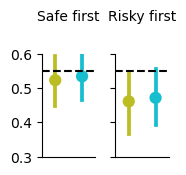

In [31]:
rnp['Order'] = rnp.index.get_level_values('risky_first').map({True:'Risky first', False:'Safe first'})
rnp['Pupil size'] = rnp.index.get_level_values('median_split_pupil')#.map({True:'Large', False:'Small'})


fac = sns.catplot(data=rnp.reset_index(), x='Pupil size', y='rnp', col='Order', kind='point', palette=palette,
                   order=['Low pupil dilation', 'High pupil dilation'],
                   errorbar=get_hdi,
                #   col_order=['Safe first', 'Risky first'],
                  aspect=.5, height=1.5*3.2*cm, legend=False)

fac.set(ylabel=None, xlabel=None, xticks=[], ylim=(0.3, 0.6))
fac.set_titles('{col_name}', y=1.25)
# fac.add_legend()

fac.map(lambda *args, **kwargs: plt.axhline(0.55, c='k', ls='--'))


plt.savefig(op.join(bids_folder, 'derivatives', 'figures', 'pupil_n1_prepost_rnp.pdf'), bbox_inches='tight')

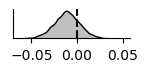

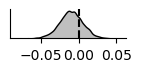

In [32]:
diff = (rnp.xs(False, 0, 'risky_first').xs('Low pupil dilation', 0, 'median_split_pupil')['rnp'] - rnp.xs(False, 0, 'risky_first').xs('High pupil dilation', 0, 'median_split_pupil')['rnp']) 

sns.kdeplot(diff, fill=True, color='k')
sns.despine()

plt.axvline(0.0, c='k', ls='--')
sns.despine()
plt.gcf().set_size_inches(1.5, .375)
plt.xlabel(None)
plt.ylabel(None)
plt.yticks([])

plt.savefig('/data/ds-risk/derivatives/figures/pupil_n1_prepost_rnp_safe_first_diff.pdf', bbox_inches='tight')

plt.figure()
diff = (rnp.xs(True, 0, 'risky_first').xs('Low pupil dilation', 0, 'median_split_pupil')['rnp'] - rnp.xs(True, 0, 'risky_first').xs('High pupil dilation', 0, 'median_split_pupil')['rnp']) 

sns.kdeplot(diff, fill=True, color='k')
sns.despine()

plt.axvline(0.0, c='k', ls='--')
sns.despine()
plt.gcf().set_size_inches(1.5, .375)
plt.xlabel(None)
plt.ylabel(None)
plt.yticks([])

plt.savefig('/data/ds-risk/derivatives/figures/pupil_n1_prepost_rnp_risky_first_diff.pdf', bbox_inches='tight')

In [33]:
print( 1-((rnp.xs(False, 0, 'risky_first').xs('Low pupil dilation', 0, 'median_split_pupil')['rnp'] - rnp.xs(False, 0, 'risky_first').xs('High pupil dilation', 0, 'median_split_pupil')['rnp']) < 0.0).mean())
print(((rnp.xs(True, 0, 'risky_first').xs('Low pupil dilation', 0, 'median_split_pupil')['rnp'] - rnp.xs(True, 0, 'risky_first').xs('High pupil dilation', 0, 'median_split_pupil')['rnp']) > 0.0).mean())

0.20550000000000002
0.2485


/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  self._figure.tight_layout(*args, **kwargs)


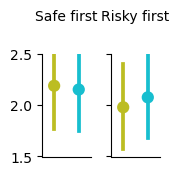

In [34]:
gamma['Order'] = gamma.index.get_level_values('risky_first').map({True:'Risky first', False:'Safe first'})
gamma['Pupil size'] = gamma.index.get_level_values('median_split_pupil')


fac = sns.catplot(data=gamma.reset_index(), x='Pupil size', y='gamma', col='Order', kind='point', palette=palette,
                   order=['Low pupil dilation', 'High pupil dilation'],
                   errorbar=get_hdi,
                   col_order=['Safe first', 'Risky first'],
                   aspect=.5, height=1.5*3.2*cm, legend=False)

fac.set(ylabel=None, xlabel=None, xticks=[], ylim=(1.5, 2.5))
fac.set_titles('{col_name}', y=1.25)

fac.map(lambda *args, **kwargs: plt.axhline(0.55, c='k', ls='--'))
# plt.tight_layout()

plt.savefig(op.join(bids_folder, 'derivatives', 'figures', 'pupil_n1_prepost_gamma.pdf'), bbox_inches='tight')

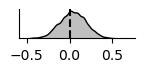

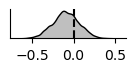

In [35]:
diff = (gamma.xs(False, 0, 'risky_first').xs('Low pupil dilation', 0, 'median_split_pupil')['gamma'] - gamma.xs(False, 0, 'risky_first').xs('High pupil dilation', 0, 'median_split_pupil')['gamma']) 

sns.kdeplot(diff, fill=True, color='k')
sns.despine()

plt.axvline(0.0, c='k', ls='--')
sns.despine()
plt.gcf().set_size_inches(1.5, .375)
plt.xlabel(None)
plt.ylabel(None)
plt.yticks([])

plt.savefig('/data/ds-risk/derivatives/figures/pupil_n1_prepost_gamma_safe_first_diff.pdf', bbox_inches='tight')

plt.figure()
diff = (gamma.xs(True, 0, 'risky_first').xs('Low pupil dilation', 0, 'median_split_pupil')['gamma'] - gamma.xs(True, 0, 'risky_first').xs('High pupil dilation', 0, 'median_split_pupil')['gamma']) 

sns.kdeplot(diff, fill=True, color='k')
sns.despine()

plt.axvline(0.0, c='k', ls='--')
sns.despine()
plt.gcf().set_size_inches(1.5, .375)
plt.xlabel(None)
plt.ylabel(None)
plt.yticks([])

plt.savefig('/data/ds-risk/derivatives/figures/pupil_n1_prepost_gamma_risky_first_diff.pdf', bbox_inches='tight')

In [36]:
print(((gamma.xs(False, 0, 'risky_first').xs('Low pupil dilation', 0, 'median_split_pupil')['gamma'] - gamma.xs(False, 0, 'risky_first').xs('High pupil dilation', 0, 'median_split_pupil')['gamma']) < 0.0).mean())
print(1-((gamma.xs(True, 0, 'risky_first').xs('Low pupil dilation', 0, 'median_split_pupil')['gamma'] - gamma.xs(True, 0, 'risky_first').xs('High pupil dilation', 0, 'median_split_pupil')['gamma']) < 0.0).mean())

0.4025
0.27049999999999996


## N2 choice

In [37]:
df, model, idata = load('probit_pupil_median_split3_n2_choice', '3t2')
intercept, gamma = extract_intercept_gamma(idata, model, df, group=True)
rnp = np.exp(intercept['intercept']/gamma['gamma']).stack([-2, -1]).to_frame('rnp')
rnp.index = rnp.index.set_levels(rnp.index.levels[1].astype(int), level=1)

gamma = gamma.stack([-2, -1])

100%|██████████| 30/30 [00:01<00:00, 28.00it/s]


N2_CHOICE


/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  self._figure.tight_layout(*args, **kwargs)


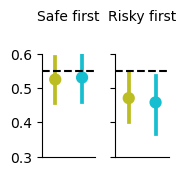

In [38]:
rnp['Order'] = rnp.index.get_level_values('risky_first').map({True:'Risky first', False:'Safe first'})
rnp['Pupil size'] = rnp.index.get_level_values('median_split_pupil')#.map({True:'Large', False:'Small'})


fac = sns.catplot(data=rnp.reset_index(), x='Pupil size', y='rnp', col='Order', kind='point', palette=palette,
                   order=['Low pupil dilation', 'High pupil dilation'],
                   errorbar=get_hdi,
                #   col_order=['Safe first', 'Risky first'],
                  aspect=.5, height=1.5*3.2*cm, legend=False)

fac.set(ylabel=None, xlabel=None, xticks=[], ylim=(0.3, 0.6))
fac.set_titles('{col_name}', y=1.25)

fac.map(lambda *args, **kwargs: plt.axhline(0.55, c='k', ls='--'))


plt.savefig(op.join(bids_folder, 'derivatives', 'figures', 'pupil_n2_choice_rnp.pdf'), bbox_inches='tight')

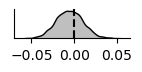

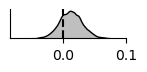

In [39]:
diff = (rnp.xs(False, 0, 'risky_first').xs('Low pupil dilation', 0, 'median_split_pupil')['rnp'] - rnp.xs(False, 0, 'risky_first').xs('High pupil dilation', 0, 'median_split_pupil')['rnp']) 

sns.kdeplot(diff, fill=True, color='k')
sns.despine()

plt.axvline(0.0, c='k', ls='--')
sns.despine()
plt.gcf().set_size_inches(1.5, .375)
plt.xlabel(None)
plt.ylabel(None)
plt.yticks([])

plt.savefig('/data/ds-risk/derivatives/figures/pupil_n2_choice_rnp_safe_first_diff.pdf', bbox_inches='tight')

plt.figure()
diff = (rnp.xs(True, 0, 'risky_first').xs('Low pupil dilation', 0, 'median_split_pupil')['rnp'] - rnp.xs(True, 0, 'risky_first').xs('High pupil dilation', 0, 'median_split_pupil')['rnp']) 

sns.kdeplot(diff, fill=True, color='k')
sns.despine()

plt.axvline(0.0, c='k', ls='--')
sns.despine()
plt.gcf().set_size_inches(1.5, .375)
plt.xlabel(None)
plt.ylabel(None)
plt.yticks([])

plt.savefig('/data/ds-risk/derivatives/figures/pupil_n2_choice_rnp_risky_first_diff.pdf', bbox_inches='tight')

/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  self._figure.tight_layout(*args, **kwargs)


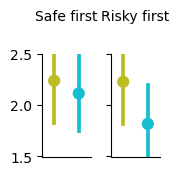

In [40]:
gamma['Order'] = gamma.index.get_level_values('risky_first').map({True:'Risky first', False:'Safe first'})
gamma['Pupil size'] = gamma.index.get_level_values('median_split_pupil')


fac = sns.catplot(data=gamma.reset_index(), x='Pupil size', y='gamma', col='Order', kind='point', palette=palette,
                   order=['Low pupil dilation', 'High pupil dilation'],
                   errorbar=get_hdi,
                   col_order=['Safe first', 'Risky first'],
                   aspect=.5, height=1.5*3.2*cm, legend=False)

fac.set(ylabel=None, xlabel=None, xticks=[], ylim=(1.5, 2.5))
fac.set_titles('{col_name}', y=1.25)

fac.map(lambda *args, **kwargs: plt.axhline(0.55, c='k', ls='--'))
# plt.tight_layout()

plt.savefig(op.join(bids_folder, 'derivatives', 'figures', 'pupil_n2_choice_gamma.pdf'), bbox_inches='tight')

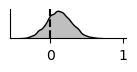

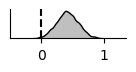

In [41]:
diff1 = (gamma.xs(False, 0, 'risky_first').xs('Low pupil dilation', 0, 'median_split_pupil')['gamma'] - gamma.xs(False, 0, 'risky_first').xs('High pupil dilation', 0, 'median_split_pupil')['gamma']) 

sns.kdeplot(diff1, fill=True, color='k')
sns.despine()

plt.axvline(0.0, c='k', ls='--')
sns.despine()
plt.gcf().set_size_inches(1.5, .375)
plt.xlabel(None)
plt.ylabel(None)
plt.yticks([])

plt.savefig('/data/ds-risk/derivatives/figures/pupil_n2_choice_gamma_safe_first_diff.pdf', bbox_inches='tight')

plt.figure()
diff2 = (gamma.xs(True, 0, 'risky_first').xs('Low pupil dilation', 0, 'median_split_pupil')['gamma'] - gamma.xs(True, 0, 'risky_first').xs('High pupil dilation', 0, 'median_split_pupil')['gamma']) 

sns.kdeplot(diff2, fill=True, color='k')
sns.despine()

plt.axvline(0.0, c='k', ls='--')
sns.despine()
plt.gcf().set_size_inches(1.5, .375)
plt.xlabel(None)
plt.ylabel(None)
plt.yticks([])

plt.savefig('/data/ds-risk/derivatives/figures/pupil_n2_choice_gamma_risky_first_diff.pdf', bbox_inches='tight')

In [42]:
print(((gamma.xs(False, 0, 'risky_first').xs('Low pupil dilation', 0, 'median_split_pupil')['gamma'] - gamma.xs(False, 0, 'risky_first').xs('High pupil dilation', 0, 'median_split_pupil')['gamma']) < 0.0).mean())
print(((gamma.xs(True, 0, 'risky_first').xs('Low pupil dilation', 0, 'median_split_pupil')['gamma'] - gamma.xs(True, 0, 'risky_first').xs('High pupil dilation', 0, 'median_split_pupil')['gamma']) < 0.0).mean())

0.23525
0.0085


In [43]:
(diff1 > diff2).mean()

0.0935

# Complex model (n_safe x order x pupil)

## N1 Pre

In [44]:
df, model, idata = load('probit_pupil_median_split2_n1_pre', '3t2')
intercept, gamma = extract_intercept_gamma(idata, model, df, group=True)
rnp = np.exp(intercept['intercept']/gamma['gamma']).stack([-2, -1]).to_frame('rnp')
rnp.index = rnp.index.set_levels(rnp.index.levels[1].astype(int), level=1)


100%|██████████| 30/30 [00:01<00:00, 27.47it/s]


N1_PRE


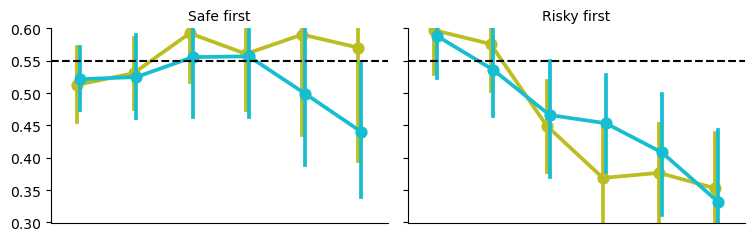

In [45]:
rnp['Order'] = rnp.index.get_level_values('risky_first').map({True:'Risky first', False:'Safe first'})
rnp['Pupil size'] = rnp.index.get_level_values('median_split_pupil')#.map({True:'Large', False:'Small'})


fac = sns.catplot(data=rnp.reset_index(), x='n_safe', hue='Pupil size', y='rnp', col='Order', kind='point', palette=palette,
                   hue_order=['Low pupil dilation', 'High pupil dilation'],
                   dodge=True,
                   errorbar=get_hdi,
                #   col_order=['Safe first', 'Risky first'],
                  aspect=1.5, height=2*3.2*cm, legend=False)

fac.set(ylabel=None, xlabel=None, xticks=[], ylim=(0.3, 0.6))
fac.set_titles('{col_name}')

fac.map(lambda *args, **kwargs: plt.axhline(0.55, c='k', ls='--'))


plt.savefig(op.join(bids_folder, 'derivatives', 'figures', 'pupil_complex_n1_prepost_rnp.pdf'), bbox_inches='tight')

/Users/gdehol/mambaforge/lib/python3.10/site-packages/pandas/core/internals/blocks.py:352: RuntimeWarning: overflow encountered in exp
  result = func(self.values, **kwargs)


0.64475


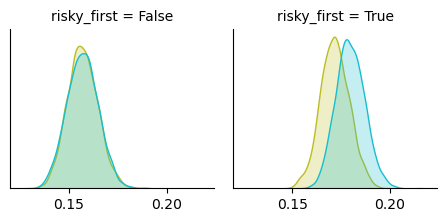

In [46]:
intercept, gamma = extract_intercept_gamma(idata, model, df, group=False)
rnp = np.exp(intercept['intercept']/gamma['gamma']).stack([-2, -1]).to_frame('rnp')
rnp = rnp[(rnp['rnp'] > 0.0) & (rnp['rnp'] < 1.0)]
rnp.index = rnp.index.set_levels(rnp.index.levels[1].astype(int), level=1)

rnp['distance_to_risk_neutral'] = (rnp['rnp'] - .55).abs()
rnp['Pupil size'] = rnp.index.get_level_values('median_split_pupil')#.map({True:'Large', False:'Small'})

tmp = rnp.groupby(['chain', 'draw', 'Pupil size', 'risky_first']).mean()

fac = sns.FacetGrid(tmp.reset_index(), hue='Pupil size', col='risky_first', palette=palette,
                #    hue_order=['Low neural uncertainty', 'High neural uncertainty'],
                    height=6.4*cm)
fac.map(sns.kdeplot, 'distance_to_risk_neutral', fill=True)

fac.set(xlabel=None, ylabel=None, yticks=[])
split = tmp['distance_to_risk_neutral'].unstack('Pupil size')
print((split[order[0]] > split[order[1]]).mean())
# plt.savefig(op.join(bids_folder, 'derivatives', 'figures', 'model-rnp_neural9_rnp_distance.pdf'), bbox_inches='tight')

## N1 post- pre

In [47]:
df, model, idata = load('probit_pupil_median_split2_n1_prepost', '3t2')
intercept, gamma = extract_intercept_gamma(idata, model, df, group=True)
rnp = np.exp(intercept['intercept']/gamma['gamma']).stack([-2, -1]).to_frame('rnp')
rnp.index = rnp.index.set_levels(rnp.index.levels[1].astype(int), level=1)


100%|██████████| 30/30 [00:00<00:00, 30.84it/s]


N1_PREPOST


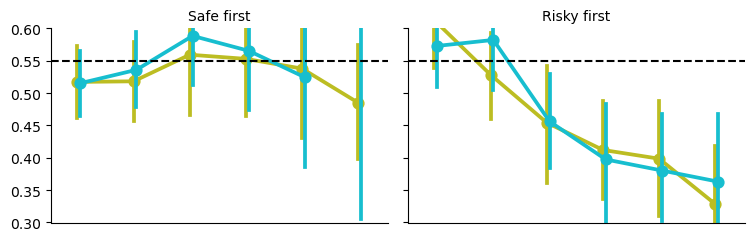

In [48]:
rnp['Order'] = rnp.index.get_level_values('risky_first').map({True:'Risky first', False:'Safe first'})
rnp['Pupil size'] = rnp.index.get_level_values('median_split_pupil')#.map({True:'Large', False:'Small'})


fac = sns.catplot(data=rnp.reset_index(), x='n_safe', hue='Pupil size', y='rnp', col='Order', kind='point', palette=palette,
                   hue_order=['Low pupil dilation', 'High pupil dilation'],
                   dodge=True,
                   errorbar=get_hdi,
                #   col_order=['Safe first', 'Risky first'],
                  aspect=1.5, height=2*3.2*cm, legend=False)

fac.set(ylabel=None, xlabel=None, xticks=[], ylim=(0.3, 0.6))
fac.set_titles('{col_name}')

fac.map(lambda *args, **kwargs: plt.axhline(0.55, c='k', ls='--'))


plt.savefig(op.join(bids_folder, 'derivatives', 'figures', 'pupil_complex_n1_prepost_rnp.pdf'), bbox_inches='tight')

/Users/gdehol/mambaforge/lib/python3.10/site-packages/pandas/core/internals/blocks.py:352: RuntimeWarning: overflow encountered in exp
  result = func(self.values, **kwargs)


0.28725


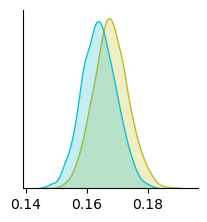

In [49]:
intercept, gamma = extract_intercept_gamma(idata, model, df, group=False)
rnp = np.exp(intercept['intercept']/gamma['gamma']).stack([-2, -1]).to_frame('rnp')
rnp = rnp[(rnp['rnp'] > 0.0) & (rnp['rnp'] < 1.0)]
rnp.index = rnp.index.set_levels(rnp.index.levels[1].astype(int), level=1)

rnp['distance_to_risk_neutral'] = (rnp['rnp'] - .55).abs()
rnp['Pupil size'] = rnp.index.get_level_values('median_split_pupil')#.map({True:'Large', False:'Small'})

tmp = rnp.groupby(['chain', 'draw', 'Pupil size']).mean()

fac = sns.FacetGrid(tmp.reset_index(), hue='Pupil size', palette=palette,
                #    hue_order=['Low neural uncertainty', 'High neural uncertainty'],
                    height=6.4*cm)
fac.map(sns.kdeplot, 'distance_to_risk_neutral', fill=True)

fac.set(xlabel=None, ylabel=None, yticks=[])
split = tmp['distance_to_risk_neutral'].unstack('Pupil size')
print((split[order[0]] > split[order[1]]).mean())
# plt.savefig(op.join(bids_folder, 'derivatives', 'figures', 'model-rnp_neural9_rnp_distance.pdf'), bbox_inches='tight')

## N2 choice

In [50]:
df, model, idata = load('probit_pupil_median_split2_n2_choice', '3t2')
intercept, gamma = extract_intercept_gamma(idata, model, df, group=True)
rnp = np.exp(intercept['intercept']/gamma['gamma']).stack([-2, -1]).to_frame('rnp')
rnp = rnp[(rnp['rnp'] > 0.0) & (rnp['rnp'] < 1.0)]
rnp.index = rnp.index.set_levels(rnp.index.levels[1].astype(int), level=1)


100%|██████████| 30/30 [00:01<00:00, 26.88it/s]


N2_CHOICE


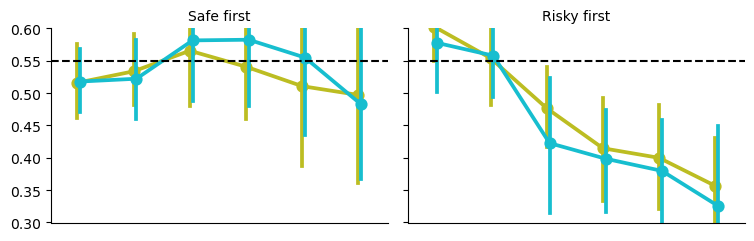

In [51]:
rnp['Order'] = rnp.index.get_level_values('risky_first').map({True:'Risky first', False:'Safe first'})
rnp['Pupil size'] = rnp.index.get_level_values('median_split_pupil')#.map({True:'Large', False:'Small'})


fac = sns.catplot(data=rnp.reset_index(), x='n_safe', hue='Pupil size', y='rnp', col='Order', kind='point', palette=palette,
                   hue_order=['Low pupil dilation', 'High pupil dilation'],
                   dodge=True,
                   errorbar=get_hdi,
                #   col_order=['Safe first', 'Risky first'],
                  aspect=1.5, height=2*3.2*cm, legend=False)

fac.set(ylabel=None, xlabel=None, xticks=[], ylim=(0.3, 0.6))
fac.set_titles('{col_name}')

fac.map(lambda *args, **kwargs: plt.axhline(0.55, c='k', ls='--'))


plt.savefig(op.join(bids_folder, 'derivatives', 'figures', 'pupil_complex_n2_choice_rnp.pdf'), bbox_inches='tight')

/Users/gdehol/mambaforge/lib/python3.10/site-packages/pandas/core/internals/blocks.py:352: RuntimeWarning: overflow encountered in exp
  result = func(self.values, **kwargs)


0.09875


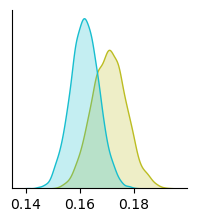

In [52]:
intercept, gamma = extract_intercept_gamma(idata, model, df, group=False)
rnp = np.exp(intercept['intercept']/gamma['gamma']).stack([-2, -1]).to_frame('rnp')
rnp = rnp[(rnp['rnp'] > 0.0) & (rnp['rnp'] < 1.0)]
rnp.index = rnp.index.set_levels(rnp.index.levels[1].astype(int), level=1)

rnp['distance_to_risk_neutral'] = (rnp['rnp'] - .55).abs()
rnp['Pupil size'] = rnp.index.get_level_values('median_split_pupil')#.map({True:'Large', False:'Small'})

tmp = rnp.groupby(['chain', 'draw', 'Pupil size']).mean()

fac = sns.FacetGrid(tmp.reset_index(), hue='Pupil size', palette=palette,
                #    hue_order=['Low neural uncertainty', 'High neural uncertainty'],
                    height=6.4*cm)
fac.map(sns.kdeplot, 'distance_to_risk_neutral', fill=True)

fac.set(xlabel=None, ylabel=None, yticks=[])
split = tmp['distance_to_risk_neutral'].unstack('Pupil size')
print((split[order[0]] > split[order[1]]).mean())
# plt.savefig(op.join(bids_folder, 'derivatives', 'figures', 'model-rnp_neural9_rnp_distance.pdf'), bbox_inches='tight')